In [22]:
from lbg_forecast.likelihood import Likelihood
from lbg_forecast.angular_power import define_cosmo
from lbg_forecast.angular_power import pk_lin
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import lbg_forecast.utils as utils
import jax_cosmo as jc


In [44]:
def trig_plot(nparams, params, F, F_marg, labels):
    
    plt.figure(figsize=(25, 25))

    #randnos = np.random.multivariate_normal(np.array([params[0], params[1]]),
    #                                         np.linalg.inv(F), 1000)
    for i in range(nparams):
        for j in range(nparams):
            if j<i:
                plt.subplot(nparams,nparams,i*nparams+j+1)
                plt.subplots_adjust(wspace=0, hspace=0)


                plt.grid(alpha=0.4, zorder=-1)

                utils.plot_contours(F, params, j, i, K=2.279, fill=True,color='k', alpha=0.3, zorder=5, ls="--", lw=2)
                utils.plot_contours(F, params, j, i, K=5.991, fill=True,color='k',  alpha=0.3, zorder=5, ls="--", lw=2)
                #plot_contours(F, params, j, i, K=9.210, fill=True,color='k',  alpha=0.3, zorder=5, ls="--", lw=2)
                    #plot_contours(F, params, j, i, K=11.618, fill=True,color='b',  alpha=0.3, zorder=5)

                utils.plot_contours(F_marg, params, j, i, K=2.279, fill=True,color='r', alpha=0.3, zorder=1, lw=2)
                utils.plot_contours(F_marg, params, j, i, K=5.991, fill=True,color='r', alpha=0.3, zorder=1, lw=2)
                    #plot_contours(F_marg, params, j, i, K=9.210, fill=True,color='r',  alpha=0.3, zorder=1)
                    #plot_contours(F_marg, params, j, i, K=11.618, fill=True,color='r', alpha=0.3, zorder=1)
                

                if(j == 0):
                    plt.ylabel(labels[i], fontsize = 32)

                if(i == nparams-1):
                    plt.xlabel(labels[j], fontsize = 32)

                plt.tick_params(axis="x", width = 2, labelsize=15)
                plt.tick_params(axis="y", width = 2, labelsize=15)

                if(i < nparams - 1):
                    plt.tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        labelbottom=False)
                    
                if(j > 0):
                    plt.tick_params(
                        axis='y',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        left=False,        # ticks along the bottom edge are off
                        labelleft=False)
                #plt.scatter(randnos[:,0], randnos[:, 1], c ='r', zorder=100, alpha=.5, s=10)


def forecast(lhood):

    params = np.array([lhood._cosmo_fid.sigma8, 
                    lhood._cosmo_fid.Omega_c, lhood._cosmo_fid.Omega_b,
                    lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                    lhood._b_lbg_u, lhood._b_lbg_g, lhood._b_lbg_r])

    labels = np.array(["$\sigma_{8}$", "$\Omega_{c}$", "$\Omega_{b}$",
                        "$h$", "$n_{s}$", "$b^{lbg}_{u}$", "$b^{lbg}_{g}$", "$b^{lbg}_{r}$"])

    F = lhood.fisher(params)
    F_marg = lhood.fisher_marg(params)

    return F, F_marg, params, labels

In [3]:
path = "./"
lhood = Likelihood(path)

Initialising likelihood
Initialisation Complete


In [4]:
params = np.array([lhood._cosmo_fid.sigma8, 
                lhood._cosmo_fid.Omega_c, lhood._cosmo_fid.Omega_b,
                lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                lhood._b_lbg_u, lhood._b_lbg_g, lhood._b_lbg_r])

params_mod = np.array([lhood._cosmo_fid.sigma8, 
                lhood._cosmo_fid.Omega_c, lhood._cosmo_fid.Omega_b,
                lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                lhood._b_lbg_u, lhood._b_lbg_g, lhood._b_lbg_r])

In [6]:
F, F_marg, params, labels = forecast(lhood)

<ErrorbarContainer object of 3 artists>

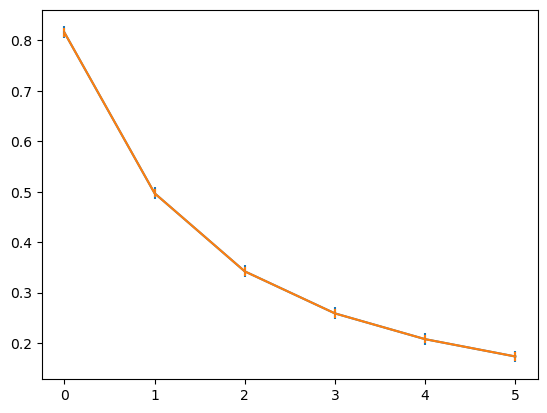

In [61]:
def sig8_at_z(sig8, z):
    cosmo = jc.Planck15(sigma8=sig8)
    return ((np.sqrt(pk_lin(cosmo, 1/8, z)/pk_lin(cosmo, 1/8, 0.0)))*cosmo.sigma8)

def prop_err(fid_sig, sig_err, z):
    sig = sig8_at_z(fid_sig, z)
    err = abs(sig8_at_z(fid_sig+sig_err, z) + sig)
    return sig, err

def get_err(F):
    cov = np.linalg.inv(F)
    sigma8_err = np.sqrt(cov[0, 0])
    return sigma8_err

sigma8_err = get_err(F)
sigma8_err_marg = get_err(F_marg)
fid_sig8 = lhood._cosmo_fid.sigma8

redshifts = []
sigmas = []
errs = []
sigmas_marg = []
errs_marg = []
for z in range(0, 6):
    sigma8_z, sigma8_err_z = prop_err(fid_sig8, sigma8_err, z)
    sigma8_z_marg, sigma8_err_z_marg = prop_err(fid_sig8, sigma8_err_marg, z)
    redshifts.append(z)
    sigmas.append(sigma8_z)
    sigmas_marg.append(sigma8_z_marg)
    errs.append(sigma8_err)
    errs_marg.append(sigma8_err_marg)

plt.errorbar(redshifts, sigmas_marg, errs_marg)
plt.errorbar(redshifts, sigmas, errs)


<ErrorbarContainer object of 3 artists>

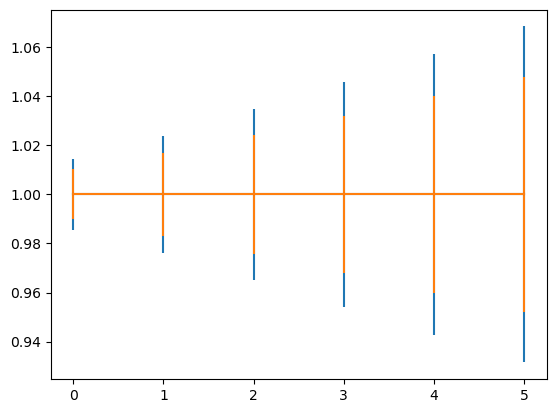

In [65]:
plt.errorbar(redshifts, np.array(sigmas_marg)/np.array(sigmas_marg), np.array(errs_marg)/np.array(sigmas_marg))
plt.errorbar(redshifts, np.array(sigmas)/np.array(sigmas), np.array(errs)/np.array(sigmas))